In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d1intextorg1/Arshad D1.xlsx
/kaggle/input/arl-acarshad/DS-1Fine Data.xlsx
/kaggle/input/cohenintextorg2/Chohen intext org.xlsx


# # 📚 Influential-Citation Classification with Sparse Hard-Kuma Rationales (SciBERT)##  

In [2]:
# ✅ All-in-One: SciBERT + L0 Selector + Classifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

# ----- 1. L0 Selector Layer -----
class L0Selector(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, 1)
        self.hard_concrete = nn.Sigmoid()

    def forward(self, hidden_states, attention_mask):
        z = self.hard_concrete(self.linear(hidden_states)).squeeze(-1)
        z = z * attention_mask
        return z

# ----- 2. Full Model -----
class RationaleClassifier(nn.Module):
    def __init__(self, model_name="allenai/scibert_scivocab_uncased"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.selector = L0Selector(hidden_dim=768)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, labels=None):
        encoded = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        token_reps = encoded.last_hidden_state  # [B, T, H]

        z = self.selector(token_reps, attention_mask)  # [B, T]
        z_expand = z.unsqueeze(-1)
        selected_reps = token_reps * z_expand

        summed = selected_reps.sum(dim=1)
        norm = z.sum(dim=1).clamp(min=1e-6).unsqueeze(-1)
        pooled = summed / norm

        logits = self.classifier(pooled).squeeze(-1)
        probs = torch.sigmoid(logits)

        if labels is not None:
            bce_loss = F.binary_cross_entropy(probs, labels.float())
            sparsity_penalty = z.mean()
            total_loss = bce_loss + 0.01 * sparsity_penalty
            return total_loss, probs, z
        return probs, z


In [3]:
# ✅ Load from Excel: DS-1Fine Data.xlsx with sheet name 'CitationSentences'
import pandas as pd

df = pd.read_excel("/kaggle/input/arl-acarshad/DS-1Fine Data.xlsx", sheet_name="CitationSentences")
df.head()




,Root_Paper_ID,Cited-by_Paper_ID,ExtractedCitationSentence,CitationClass
0,A00-1043,C00-2140,since we only use shallow methods for textual ...,0
1,A00-1043,P02-1057,sentence simplification systems are capable of...,0
2,A97-1011,W09-1118,each token is represented using a fairly stand...,0
3,A97-1011,A00-2017,the training and the test data were processed ...,0
4,A97-1011,C00-2099,the only other high delity computational rende...,0


In [4]:
# Preview it
print(df.columns)
df = df[["ExtractedCitationSentence", "CitationClass"]]  # Rename if column names are different
df = df.rename(columns={"CitationClass": "label"})  # Ensure label column is named 'label'

# Drop missing values
df = df.dropna(subset=["ExtractedCitationSentence", "label"])

# Convert label to int if needed
df["label"] = df["label"].astype(int)

# Continue with HuggingFace Dataset conversion
from datasets import Dataset
dataset = Dataset.from_pandas(df)

Index(['Root_Paper_ID', 'Cited-by_Paper_ID', 'ExtractedCitationSentence',
       'CitationClass'],
      dtype='object')


In [5]:
dataset = Dataset.from_pandas(df)

# ----- Tokenizer -----
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

def tokenize(example):
    return tokenizer(example["ExtractedCitationSentence"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ----- Dataloader -----
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# ----- Initialize Model -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RationaleClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# ----- Train -----
print("Starting training...")
for epoch in range(3):  # You can increase to 5+
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        loss, probs, z = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend((probs > 0.5).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch + 1} | Loss: {total_loss:.4f} | Macro-F1: {epoch_f1:.4f}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

2025-08-20 08:19:42.181966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755677982.381840      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755677982.446997      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Starting training...
Epoch 1 | Loss: 55.4492 | Macro-F1: 0.5786
Epoch 2 | Loss: 44.2402 | Macro-F1: 0.7283
Epoch 3 | Loss: 33.1562 | Macro-F1: 0.8176


In [7]:
# ----- Inspect Rationale for One Example -----
model.eval()

sample_text = "This approach follows the previously established model by Smith et al. (2019), which significantly improved results in this domain."

inputs = tokenizer(sample_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

with torch.no_grad():
    probs, z = model(input_ids, attention_mask)

pred = "Influential" if probs.item() > 0.5 else "Non-influential"
print(f"\nPrediction: {pred} ({probs.item():.4f})")

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
rationale = z[0].cpu().numpy()

print("\nRationale Tokens:")
for tok, score in zip(tokens, rationale):
    if score > 0.5:
        print(f"  {tok} ({score:.2f})")



Prediction: Influential (0.9123)

Rationale Tokens:
  [CLS] (0.74)
  this (0.76)
  approach (0.65)
  follows (0.57)
  the (0.71)
  previously (0.76)
  established (0.78)
  model (0.59)
  by (0.64)
  smith (0.62)
  et (0.74)
  al (0.69)
  . (0.70)
  ( (0.75)
  201 (0.62)
  ##9 (0.66)
  ) (0.58)
  which (0.69)
  significantly (0.71)
  improved (0.79)
  results (0.64)
  in (0.63)
  this (0.75)
  domain (0.70)
  . (0.70)
  [SEP] (0.70)



--- Evaluation Metrics ---
F1 Score:     0.90
Precision:    0.83
Recall:       0.99
Accuracy:     0.92
Confusion Matrix:
 [[369  53]
 [  4 267]]

Sentence 0:
since we only use shallow methods for textual analysis that do not generate a dependency structure we cannot use complex methods for text reduction as described eg in

Top 10 Important Tokens:
        Token  Importance
26  described    0.787307
10       that    0.760162
4         use    0.734798
25         as    0.719641
20    complex    0.714861
12        not    0.694180
5     shallow    0.692757
14          a    0.655098
11         do    0.637540
2          we    0.612312
✅ Saved token importances to token_importance_example_0.csv


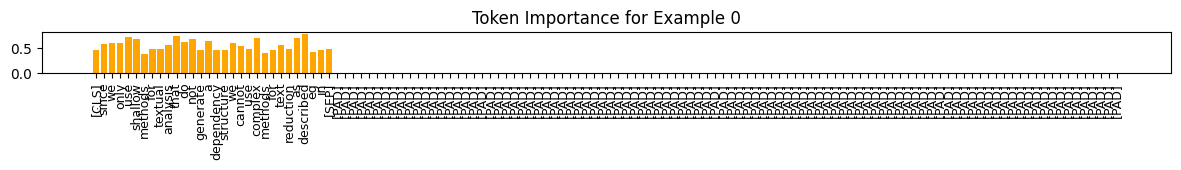


Sentence 1:
sentence simplification systems are capable of compressing long sentences by deleting unimportant words and phrases

Top 10 Important Tokens:
             Token  Importance
13            unim    0.599958
5          capable    0.596334
4              are    0.525483
1         sentence    0.519247
3          systems    0.479531
12        deleting    0.467672
6               of    0.433776
2   simplification    0.323545
11              by    0.289337
0            [CLS]    0.284069
✅ Saved token importances to token_importance_example_1.csv


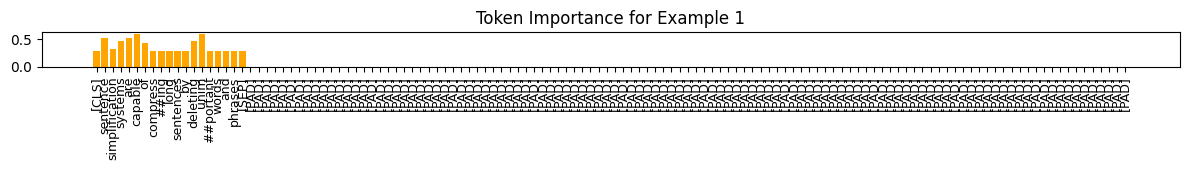


Sentence 2:
each token is represented using a fairly standard menagerie of features including such stemming from the surface appearance of the token eg contains dollar length in characters calculated based on linguistic pre processing made with the english functional dependency grammar eg case part of speech fetched from precompiled lists of information eg is first name and features based on predictions concerning the context of the token eg class of previous token

Top 10 Important Tokens:
       Token  Importance
7     fairly    0.794646
63     based    0.726133
9        men    0.713874
6          a    0.704536
11      ##ie    0.702539
64        on    0.702457
51      prec    0.671656
57        eg    0.661551
8   standard    0.661521
39   english    0.657190
✅ Saved token importances to token_importance_example_2.csv


In [ ]:
# ------------------- 5. Evaluation -------------------
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        probs, _ = model(input_ids, attention_mask)
        all_preds.extend((probs > 0.5).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n--- Evaluation Metrics ---")
print(f"F1 Score:     {f1:.2f}")
print(f"Precision:    {precision:.2f}")
print(f"Recall:       {recall:.2f}")
print(f"Accuracy:     {accuracy:.2f}")
print("Confusion Matrix:\n", cm)

# ------------------- 6. Token Highlighting Visualization -------------------
def visualize_highlight(example_idx=0, save_csv=True):
    model.eval()
    input_ids = dataset[example_idx]["input_ids"].unsqueeze(0).to(device)
    attention_mask = dataset[example_idx]["attention_mask"].unsqueeze(0).to(device)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    with torch.no_grad():
        _, z = model(input_ids, attention_mask)

    z = z[0].cpu().numpy()

    # Create dataframe for token importances
    token_importances = pd.DataFrame({
        "Token": tokens,
        "Importance": z
    })

    # Print top 10 tokens by importance
    print("\nTop 10 Important Tokens:")
    print(token_importances.sort_values("Importance", ascending=False).head(10))

    # Save to CSV if required
    if save_csv:
        filename = f"token_importance_example_{example_idx}.csv"
        token_importances.to_csv(filename, index=False)
        print(f"✅ Saved token importances to {filename}")

    # Plot
    plt.figure(figsize=(12, 1.8))
    plt.bar(range(len(z)), z, color='orange')
    plt.xticks(range(len(z)), tokens, rotation=90, fontsize=9)
    plt.title(f"Token Importance for Example {example_idx}")
    plt.tight_layout()
    plt.show()

    return token_importances


# Visualize a few examples
for idx in range(3):
    print(f"\nSentence {idx}:")
    print(df.iloc[idx]["ExtractedCitationSentence"])
    token_data = visualize_highlight(idx)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_highlight_circular(example_idx=0):
    model.eval()
    input_ids = dataset[example_idx]["input_ids"].unsqueeze(0).to(device)
    attention_mask = dataset[example_idx]["attention_mask"].unsqueeze(0).to(device)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    with torch.no_grad():
        _, z = model(input_ids, attention_mask)

    z = z[0].cpu().numpy()

    # Remove special tokens for cleaner view (optional)
    cleaned_tokens, cleaned_z = [], []
    for token, score in zip(tokens, z):
        if token not in ["[CLS]", "[SEP]", "[PAD]"]:
            cleaned_tokens.append(token)
            cleaned_z.append(score)

    num_tokens = len(cleaned_tokens)
    angles = np.linspace(0, 2 * np.pi, num_tokens, endpoint=False).tolist()

    cleaned_z += cleaned_z[:1]  # repeat first value to close the circle
    angles += angles[:1]        # same for angle
    cleaned_tokens += cleaned_tokens[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'polar': True})
    ax.bar(angles[:-1], cleaned_z[:-1], width=0.3, color='orange', alpha=0.7)

    ax.set_xticks(angles)
    ax.set_xticklabels(cleaned_tokens, fontsize=10)
    ax.set_yticklabels([])
    ax.set_title(f"Circular Token Importance — Example {example_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize examples in circular form
for idx in range(3):
    print(f"\nSentence {idx}:")
    print(df.iloc[idx]["ExtractedCitationSentence"])
    visualize_highlight_circular(idx)


In [ ]:
from IPython.display import display, HTML

def classify_and_highlight_colored(sentence):
    model.eval()
    
    # Tokenize input
    encoding = tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        probs, z = model(input_ids, attention_mask)

    pred_label = "Influential" if probs.item() > 0.5 else "Non-Influential"
    z = z[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Build colored HTML output
    highlighted_sentence = ""
    for token, score in zip(tokens, z):
        if token in tokenizer.all_special_tokens:
            continue
        word = token.replace("##", "")
        if score > 0.5:
            highlighted_sentence += f"<span style='color: red; font-weight: bold'>{word}</span> "
        else:
            highlighted_sentence += f"{word} "

    display(HTML(f"""
    <div style="border:1px solid #ddd; padding:10px; border-radius:10px">
        <h4>🔎 Input Sentence:</h4>
        <p>{sentence}</p>
        <h4>🧠 Prediction: <span style='color: {"green" if pred_label=="Influential" else "gray"}'>{pred_label}</span></h4>
        <h4>🖍️ Highlighted Rationale:</h4>
        <p style="font-family:monospace; font-size: 16px;">{highlighted_sentence}</p>
    </div>
    """))

# 🔁 Interactive loop for Kaggle/Notebook
while True:
    user_input = input("Enter a citation sentence (or type 'exit' to stop):\n")
    if user_input.lower() == 'exit':
        break
    classify_and_highlight_colored(user_input)
